# Prerequisites

### Import the Relevant Libraries


In [1]:
import csv
import random
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

# Classes

### Student

In [2]:
class Student:
    def __init__(self, record):
        self.cls = record["Tutorial Group"]
        self.id = record["Student ID"]
        self.dept = record["School"]
        self.name = record["Name"]
        self.gender = record["Gender"]
        self.gpa = float(record["CGPA"])
        self.group = None  # 待会分进小组，英文是Team

    def __repr__(self):
        return f"Student(ID={self.id}, Cls={self.cls}, GPA={self.gpa:.2f}, Group={self.group})"

    def to_dict(self):
        return {
            "Tutorial Group": self.cls,
            "Student ID": self.id,
            "School": self.dept,
            "Name": self.name,
            "Gender": self.gender,
            "CGPA": self.gpa,
            "Team": self.group,
        }

### Group

In [3]:
GROUPING_SIZE = 5

class Group:

    WEIGHT_GENDER = 0.5
    WEIGHT_DEPT = 0.5

    def __init__(self, name, size=GROUPING_SIZE):
        self.name = name
        self.size_limit = size
        self.members = []
        self.stats = {
            "count": 0,
            "gender_counts": defaultdict(int),
            "unique_depts": set(),
            "gpas": [],
        }

    def is_full(self):
        return self.stats["count"] >= self.size_limit

    def add_member(self, student):
        self.members.append(student)
        student.group = self.name

        self.stats["count"] += 1
        self.stats["gender_counts"][student.gender] += 1
        self.stats["gpas"].append(student.gpa)

    def remove_member(self, student):
        """Remove member and update statistics"""
        if student not in self.members:
            return  # Defensive programming: student not in group, exit

        # 1. Remove member
        self.members.remove(student)
        student.group = None

        # 2. Update counters
        self.stats["count"] -= 1
        self.stats["gender_counts"][student.gender] -= 1

        # 3. Update department set (your improved logic)
        same_dept_count = sum(1 for m in self.members if m.dept == student.dept)
        if same_dept_count == 0:  # Note: use == 0 here since student is already removed from members
            self.stats["unique_depts"].discard(student.dept)  # discard avoids exception if not present

        # 4. Rebuild GPA list (safest way)
        self.stats["gpas"] = [m.gpa for m in self.members]



    def get_diversity_score(self, student_to_add=None, full_metrics=False):
        temp_stats = self.stats.copy()
        if student_to_add:
            temp_count = self.stats["count"] + 1
            temp_m = self.stats["gender_counts"].get("Male", 0) + (
                1 if student_to_add.gender == "Male" else 0
            )
            temp_f = self.stats["gender_counts"].get("Female", 0) + (
                1 if student_to_add.gender == "Female" else 0
            )
            temp_depts = self.stats["unique_depts"].copy()
            temp_depts.add(student_to_add.dept)
            temp_gpas = self.stats["gpas"] + [student_to_add.gpa]
        else:
            temp_count = self.stats["count"]
            if temp_count == 0:
                return (
                    0
                    if not full_metrics
                    else {
                        "gender_score": 0,
                        "dept_score": 0,
                        "gpa_variance": 0,
                        "total_score": 0,
                    }
                )
            temp_m = self.stats["gender_counts"].get("Male", 0)
            temp_f = self.stats["gender_counts"].get("Female", 0)
            temp_depts = self.stats["unique_depts"]
            temp_gpas = self.stats["gpas"]

        # 1. gender score (0.0 - 1.0)
        gender_diff = abs(temp_m - temp_f)
        gender_score = 1 - (gender_diff / temp_count)

        # 2. depart score (0.0 - 1.0)
        dept_score = len(temp_depts) / temp_count

        # 3. GPA var (after full)
        gpa_variance = 0
        if full_metrics and temp_count > 1:
            mean_gpa = sum(temp_gpas) / temp_count
            gpa_variance = sum([(gpa - mean_gpa) ** 2 for gpa in temp_gpas]) / (
                temp_count - 1
            )

        total_score = (gender_score * self.WEIGHT_GENDER) + (
            dept_score * self.WEIGHT_DEPT
        )

        if full_metrics:
            return {
                "gender_score": gender_score,
                "dept_score": dept_score,
                "gpa_variance": gpa_variance,
                "total_score": total_score,
            }
        return total_score


###writtern by HaihengL

# Functions

### Read From CSV

We try as much as possible to not use built in tools to analyse the file

Complete with **data formatting** and **data validation** for both **header** and **records** 

<details>
    <summary>Click to expand</summary>

#### **Constants**
`REQUIRED_HEADERS` (`tuple`)**:** These are the exact headers we are expecting to receive. We will specify the order later

`IS_ORDERED` (`bool`)**:** This is the default value for the is_ordered variable in multiple functions. 
**The default is: `False`——Order does not matter**

#### **Functions**
`validate_record()`**:** **Takes In** a line of record `list[str]` **gives out** validation `bool`

`symmetric_difference()`**:** **Takes in** expected values and received values both `list[str]` **gives out** missing and unexpected values together `tuple[list[str]]`

`validate_headers()`**:** **Takes in** headers `list[str]` and flag `bool` for whether it is ordered *(defaults to `IS_ORDERED`)* **gives out** validation `bool`

`format_row()`**:** **Takes in** raw row line `str` **gives out** formatted row `list[str]`

`parse_records()`**:** **Takes in** raw record lines `list[str]` **gives out** formatted and validated record lines `list[list[str]]`

`parse_headers()`**:** **Takes in** raw header line `str` and flag `bool` for whether it is ordered *(defaults to `IS_ORDERED`)* **gives out** formatted and validated record lines in `list[str]`

`parse_csv()`**:** **Takes in** file path `str` and flag `bool` for whether it is ordered *(defaults to `IS_ORDERED`)* **gives out** header and records in this order, in `tuple[list[str],list[list[str]]]`

`load_csv()`**:** **Takes in** file path in `str` and flag `bool` for whether it is ordered *(defaults to `IS_ORDERED`)* **gives out** students grouped by class `dict[str, list[Student]]`

</details>

#### Constants

In [5]:
# Requirements
# - Should not be changeable by code
# - Should preserve order by default, as order does matter in CSVs sometimes
#
# Tuple is the best choice
# We can convert it to a frozenset later when order doesnt matter, if necessary

REQUIRED_HEADERS: tuple = (
    "Tutorial Group",
    "Student ID",
    "School",
    "Name",
    "Gender",
    "CGPA",
)

IS_ORDERED: bool = False

#### Validation Helper

In [6]:
# --- Validation Helpers ---
def validate_record(record: list[str]) -> bool:
    """Check whether there are any invalid conditions, fail-fast

    Presence Check
    - Fail if there is an empty row for records

    Length Check
    - Fail if the number of records doesnt match the number of required headers
    """

    # Presence Check
    if not record:
        print("Error: Empty Record")
        return False

    # Length Check
    if len(record) != len(REQUIRED_HEADERS):
        print("Error: Mismatched record length with required headers")
        return False


    # Did not fail any check
    return True

def symmetric_difference(expected: list[str], received: list[str]) -> tuple[list[str], list[str]]:
    """Manual Implementation of Symmetric Difference

    Symmetric Difference is used as a set operation————it should not care for duplicates
    - Thus, we have to check if the item is not already in the missing or unexpected list before adding it to avoid duplicates
    """

    missing = []
    unexpected = []

    for item in expected:
        if (item not in received) and (item not in missing):
            missing.append(item)

    for item in received:
        if (item not in expected) and (item not in unexpected):
            unexpected.append(item)

    return (missing, unexpected)

def validate_headers(headers: list[str], is_ordered: bool = IS_ORDERED) -> bool:
    """Check whether there are any invalid conditions, fail-fast

    Presence Check
    - Fails if headers are empty

    Type Check
    - Fails if its not alphabetic (Unicode)

    Length Check
    - Fails if they are not the same length

    Element Check
    - Check for unique headers
    - Use Symmetric Difference to Check, implemented manually instead of using set operators in python
    - Fails if symmetric difference exists

    Ordered Check (Only if header is ordered)
    - Headers checked per position explicitly instead of just using == so it is easier for the user
    - Also easier to debug
    - Fails if any one of headers doesnt match
    """

    # Presence Check
    if not headers:
        print("Error: Header is empty")

        return False

    # Type Check
    for header in headers:
        for char in header:
            if not (char.isalpha() or char.isspace()):
                print("Error: Header is not a valid character")

                return False

    # Length Check
    num_expected: int = len(REQUIRED_HEADERS)
    num_received: int = len(headers)

    if num_received != num_expected:
        print("Error: Wrong number of headers")
        print(f"Expected: {num_expected} headers")
        print(f"Received: {num_received} headers")

        return False

    # Member Check
    missing: list[str]
    unexpected: list[str]
    missing, unexpected = symmetric_difference(
        expected=REQUIRED_HEADERS, received=headers
    )

    if missing or unexpected:
        print("Error: Header mismatches")
        print(f"Expected: {REQUIRED_HEADERS}")
        print(f"Missing: {missing}")
        print(f"Unexpected: {unexpected}")

        return False

    # Order Check
    if is_ordered:
        # Based off REQUIRED_HEADERS
        for i, header_expected in enumerate(REQUIRED_HEADERS):
            header_received = headers[i]

            if header_received != header_expected:
                print("Error: Wrong header order")
                print(f"First mismatch at {i}-th header: {headers[i]}")
                print(f"Expected: {REQUIRED_HEADERS}")
                print(f"Received: {headers}")

                return False

    # All checks didnt fail
    return True

#### Format Helper

In [7]:
# --- Format Helpers ---
def format_row(raw_row_line: str) -> list[str]:
    """Explicit code for turning a string of comma-separated row values into a list of strings

    - Splits string by comma and populate into a list
    - Strips leading/trailing characters (whitespace, newline, etc) per header
    - Returns list of clean header strings

    Idiomatic Equivalent: List comprehension with chained methods
    """
    raw_fields: list[str] = raw_row_line.split(",")
    # print(raw_fields)

    fields = []
    for raw_field in raw_fields:
        fields.append(raw_field.strip())

    # print(fields)
    return fields

#### Parse CSV

In [8]:
# --- Parse Helpers ---
def parse_records(raw_record_lines: list[str]) -> list[list[str]] | None:
    '''Format and validate records'''

    records: list[list[str]] = []
    for raw_record_line in raw_record_lines:
        record: list[str] = format_row(raw_record_line)
        records.append(record)

    for record in records:
        if not validate_record(record):
            return None

    print("Successful: Records Validated")

    return records

def parse_headers(raw_header_line: str, is_ordered: bool = IS_ORDERED) -> list[str] | None:
    """Format and validate headers"""

    headers: list[str] = format_row(raw_header_line)

    if not validate_headers(headers, is_ordered=is_ordered):
       return None

    print("Successful: Headers Validated")

    return headers


# --- Main Parser ---
def parse_csv(file_path: str, is_ordered: bool = IS_ORDERED) -> tuple[list[str], list[list[str]]] | None:
    """Load the data and instantiate Student objects, organized by class(tut group).

    Manage files using context manager
    - Explicitly specify mode of access and encoding scheme
    - Catch some common errors like FileNotFoundError using try-except block

    Retrieve the raw headers by stepping into the first line of the file
    - Do an Empty File Check as well using try-except block

    Retrieve records using a loop on the rest of the file iterator

    Parse headers and records using helper functions
    - Involves formatting and validation

    Returns (headers, records) tuple, none otherwise
    """

    try:
        with open(file_path, mode="r", encoding="utf-8") as file:

            # Get raw headers and records
            try:
                raw_header_line: str = next(file)
            except StopIteration:
                print("Unsuccessful: CSV File is empty")
                return None

            print("Successful: Retrieve raw header line")

            raw_record_lines: list[str] = []
            for line in file: # This is the remaining iterator, not the entire file anymore
                raw_record_lines.append(line)

            print("Successful: Retrieve raw record lines")

            # Parse them
            headers: list[str] = parse_headers(raw_header_line)
            if headers is None:
                print("Unsuccessful: Parse headers")
                return None

            print("Successful: Parse headers")

            records: list[list[str]] = parse_records(raw_record_lines)
            if records is None:
                print("Unsuccessful: Parse record")
                return None

            print("Successful: Parse record")

    except FileNotFoundError:
        print(f"Error：File '{file_path}' Not Found")
        return None

    except UnicodeDecodeError:
        print("Error: Encoding not in utf-8")
        return None

    return (headers, records)

#### Load CSV

In [9]:
# --- Load CSV ---
def load_csv(file_path: str, is_ordered: bool = IS_ORDERED) -> dict[str, list[Student]]:
    """Loads the CSV into a dictionary of students
    """
    students_by_class = {}

    data = parse_csv(file_path, is_ordered=is_ordered)

    if data is None:
        return None

    headers: str
    records: list[str]
    headers, records = data


    # Create a Student Object per row

    students: list = []

    ## Go through each row
    for record in records:

        ## Go through the index of header, as header dictates the rows
        record_map: dict = {}
        for i in range(len(headers)):
            key = headers[i]
            value = record[i]
            record_map[key] = value

        # Convert to Student object
        student: Student = Student(record_map)

        # Add Student object into a list
        students.append(student)

    # Sort students by student class into a new dict
    students_by_class: dict[str, list[Student]] = {}
    for student in students:

        # Check if student class is already added in dict, add if not
        if student.cls not in students_by_class:
            students_by_class[student.cls] = []

        # Add student by its class
        students_by_class[student.cls].append(student)

    return students_by_class


### Grouping Engine

In [4]:
class GroupingEngine:
    def __init__(self, students_list, group_size=GROUPING_SIZE):
        self.students = students_list
        self.group_size = group_size
        self.num_students = len(students_list)
        self.num_groups = self.num_students // group_size

        self.groups = []
        for i in range(self.num_groups):
            self.groups.append(Group(name=f"G{i+1}", size=group_size))

    def run_greedy_assignment(self):
        # sort based on GPA
        self.students.sort(key=lambda s: s.gpa, reverse=True)

        for student in self.students:
            best_group = None
            max_diversity_score = -1

            for group in self.groups:
                if group.is_full():
                    continue

                score = group.get_diversity_score(student_to_add=student)

                if score > max_diversity_score:
                    max_diversity_score = score
                    best_group = group

                elif (
                    score == max_diversity_score
                    and best_group
                    and group.stats["count"] < best_group.stats["count"]
                ):
                    best_group = group

            if best_group:
                best_group.add_member(student)

    def run_local_swap_optimization(self, max_iterations=2000):
        # try to random swap to opti the local best problem
        def calculate_engine_score():
            """calculate score of whole groups"""
            scores = [g.get_diversity_score(full_metrics=False) for g in self.groups]
            return sum(scores) / len(scores) if scores else 0

        current_best_score = calculate_engine_score()

        # print(f"  local opti score: {current_best_score:.4f}")

        for _ in range(max_iterations):
            # 1. try 2 random groups
            if len(self.groups) < 2:
                return
            group_A, group_B = random.sample(self.groups, 2)

            # 2. try 2 random member
            if not group_A.members or not group_B.members:
                continue
            student_A = random.choice(group_A.members)
            student_B = random.choice(group_B.members)

            # 3. try swap
            score_A_old = group_A.get_diversity_score()
            score_B_old = group_B.get_diversity_score()
            old_local_score = score_A_old + score_B_old

            # 4. try to use a simple cals method to simulate after swap to get score
            def simple_diversity_calc(members):
                if not members:
                    return 0
                temp_m = sum(1 for s in members if s.gender == "M")
                temp_f = sum(1 for s in members if s.gender == "F")
                gender_score = 1 - abs(temp_m - temp_f) / len(members)
                dept_score = len({s.dept for s in members}) / len(members)
                return (gender_score * Group.WEIGHT_GENDER) + (
                    dept_score * Group.WEIGHT_DEPT
                )

            temp_A_members = [s for s in group_A.members if s != student_A] + [
                student_B
            ]
            temp_B_members = [s for s in group_B.members if s != student_B] + [
                student_A
            ]

            score_A_new = simple_diversity_calc(temp_A_members)
            score_B_new = simple_diversity_calc(temp_B_members)
            new_local_score = score_A_new + score_B_new

            # 5. yes swap
            if new_local_score > old_local_score:
                group_A.remove_member(student_A)
                group_B.remove_member(student_B)

                group_A.add_member(student_B)
                group_B.add_member(student_A)

                current_best_score = calculate_engine_score()
                # print(f"  接受交换。新得分: {current_best_score:.4f}")

    def get_all_grouped_students(self):
        """返回所有已分组的学生列表"""
        return self.students

    def get_diversity_report(self):
        """生成报告"""
        report = []
        for g in self.groups:
            metrics = g.get_diversity_score(full_metrics=True)
            report.append({"Class": self.students[0].cls, "Group": g.name, **metrics})
        return report

### Run Grouping

In [10]:
# --- Grouping Caller ---
def run_full_grouping_process(students_by_class):
    """ensure isolate the class(tut group) when grouping"""
    all_grouped_students = []
    all_diversity_reports = []

    for class_name, students in students_by_class.items():
        print(f"\n grouping tut: {class_name}")

        # 1. init and isolate class
        engine = GroupingEngine(students, group_size=5)

        # 2. greedy assign
        print("  greedy assign...")
        engine.run_greedy_assignment()

        # 3. local random swap
        """max_iterations is a changable data, try different to find the balance between efficiency and result"""
        #print("  local opti...")
        #engine.run_local_swap_optimization(max_iterations=5000)

        # 4. collect result and get rerport
        all_grouped_students.extend(engine.get_all_grouped_students())
        all_diversity_reports.extend(engine.get_diversity_report())

    return all_grouped_students, all_diversity_reports

### Write To CSV

Decided to use the built-in methods and functions to achieve this

In [11]:
# output to CSV, feel free to modify this part
def write_results_to_csv(data, file_path):
    """grouping result to CSV"""

    if not data:
        print("no data available")
        return

    fieldnames = [
        "Tutorial Group",
        "Student ID",
        "School",
        "Name",
        "Gender",
        "CGPA",
        "Team",
    ]
    try:
        with open(file_path, mode="w", newline="", encoding="utf-8") as file:
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows([s.to_dict() for s in data])
        print(f"\n successfully written to '{file_path}'。")
    except Exception as e:
        print(f"error when wrting to csv: {e}")

### Data Visualiser

In [12]:
# visual data, feel free to modify this part
def display_evaluation(reports):
    """print report"""
    gender_scores = [r["gender_score"] for r in reports]
    dept_scores = [r["dept_score"] for r in reports]
    gpa_variances = [r["gpa_variance"] for r in reports]

    print(
        f"  Average gender diversity score: {sum(gender_scores) / len(gender_scores):.4f} (goal : 1.0)"
    )
    print(
        f"  Average school diversity score: {sum(dept_scores) / len(dept_scores):.4f} (goal : 1.0)"
    )
    print(
        f"  The average GPA variance of all groups: {sum(gpa_variances) / len(gpa_variances):.4f} (goal : max)"
    )


def visualize_results(all_grouped_students, sample_class_name):
    """Visualize the GPA and gender distribution of a class."""
    class_data = [s for s in all_grouped_students if s.cls == sample_class_name]

    if not class_data:
        print(f"can not fint {sample_class_name} data for visualize")
        return

    # Prepare GPA box and whisker plot data
    gpa_by_group = defaultdict(list)
    gender_counts = defaultdict(lambda: defaultdict(int))

    for s in class_data:
        gpa_by_group[s.group].append(s.gpa)
        gender_counts[s.group][s.gender] += 1

    group_labels = sorted(gpa_by_group.keys())
    gpa_data = [gpa_by_group[g] for g in group_labels]

    # --- 1. GPA Balance Visualization (Box and Whisker Plot) ---
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=gpa_data, orient="v", showfliers=False, palette="Set2")
    plt.xticks(range(len(group_labels)), group_labels)
    plt.title(f"{sample_class_name} - GPA Balance (Box and Whisker Plot)", fontsize=16)
    plt.xlabel("team")
    plt.ylabel("CGPA")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

    # --- 2. Gender Diversity Visualization (Stacked Bar Chart) ---
    gender_df = {
        "Group": group_labels,
        "Male": [gender_counts[g].get("M", 0) for g in group_labels],
        "Female": [gender_counts[g].get("F", 0) for g in group_labels],
        "Other": [
    sum(v for k, v in gender_counts[g].items() if k not in ("M", "F")) for g in group_labels
]

    }

    fig, ax = plt.subplots(figsize=(14, 6))
    bar_m = ax.bar(gender_df["Group"], gender_df["Male"], label="Male", color="#1f77b4")
    bar_f = ax.bar(
        gender_df["Group"],
        gender_df["Female"],
        bottom=gender_df["Male"],
        label="Female",
        color="#ff7f0e",
    )

    ax.set_title(
        f"{sample_class_name} - Group Gender Diversity (stacked bar chart)", fontsize=16
    )
    ax.set_xlabel("Team")
    """this may be replaced by other number"""
    ax.set_ylabel("people(max 5)")
    ax.legend(title="gender")
    plt.show()

# Main Interface

Successful: Retrieve raw header line
Successful: Retrieve raw record lines
Successful: Headers Validated
Successful: Parse headers
Successful: Records Validated
Successful: Parse record

 grouping tut: G-1
  greedy assign...

 grouping tut: G-10
  greedy assign...

 grouping tut: G-100
  greedy assign...

 grouping tut: G-101
  greedy assign...

 grouping tut: G-102
  greedy assign...

 grouping tut: G-103
  greedy assign...

 grouping tut: G-104
  greedy assign...

 grouping tut: G-105
  greedy assign...

 grouping tut: G-106
  greedy assign...

 grouping tut: G-107
  greedy assign...

 grouping tut: G-108
  greedy assign...

 grouping tut: G-109
  greedy assign...

 grouping tut: G-11
  greedy assign...

 grouping tut: G-110
  greedy assign...

 grouping tut: G-111
  greedy assign...

 grouping tut: G-112
  greedy assign...

 grouping tut: G-113
  greedy assign...

 grouping tut: G-114
  greedy assign...

 grouping tut: G-115
  greedy assign...

 grouping tut: G-116
  greedy assign..

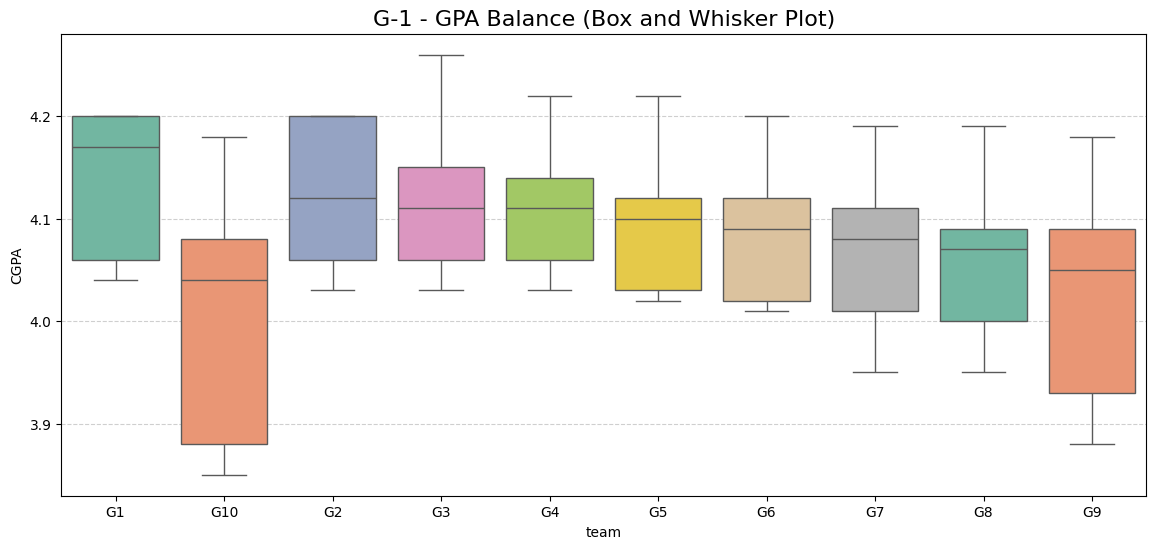

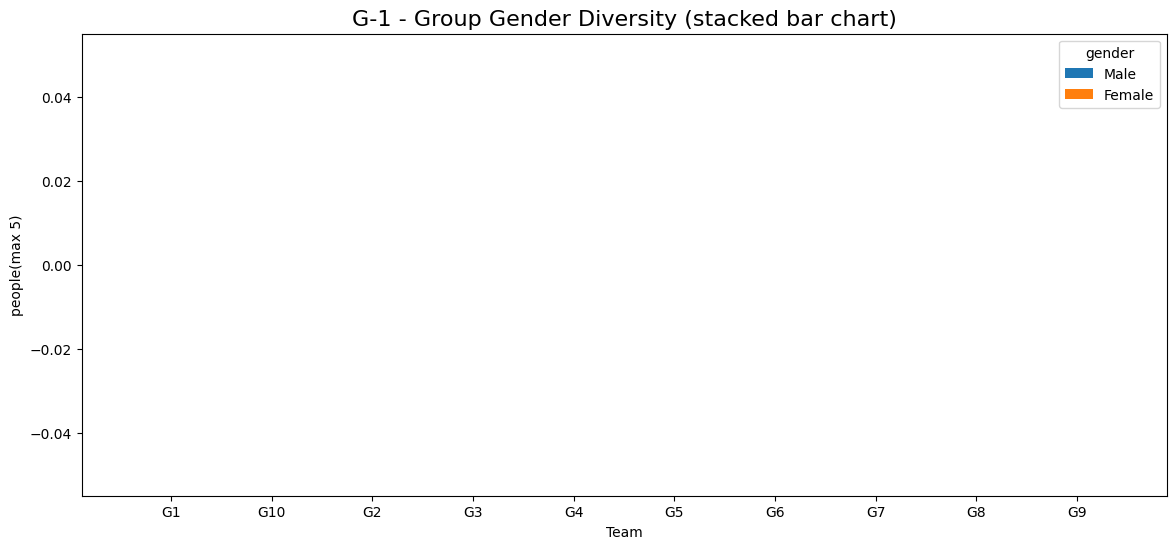

In [13]:
def main():
    # Make sure the file 'records.csv' exists (in root dic). Ok to replace with target path
    INPUT_FILE = "data/records.csv"
    OUTPUT_FILE = "grouped-students-output.csv"

    # 1. load data
    students_by_class = load_csv(INPUT_FILE)
    if not students_by_class:
        print("Error: File not read loaded properly")
        return

    # 2. Grouping and Optimizing
    all_grouped_students, all_diversity_reports = run_full_grouping_process(
        students_by_class
    )

    # 3. Write Out
    write_results_to_csv(all_grouped_students, OUTPUT_FILE)

    # 4. Evaluation
    if all_diversity_reports:
        display_evaluation(all_diversity_reports)

    # 5. Visualization (select the first class as representative)
    if students_by_class:
        sample_class = next(iter(students_by_class.keys()))
        print(f"\n--- Generate visual charts for the class '{sample_class}'  ---")
        visualize_results(all_grouped_students, sample_class)


if __name__ == "__main__":

    main()